# Gapfilling of raw data from FLux Alpes Stations at Col du Lautaret.


---
This notebook aims to build a coherent forcing file for crocus simulations. To that, raw data from Flux Alpes meteorological stations is used. Each small gap is filled with linear interpolation except for precipitation data. Precipitations are first corrected with a coefficient of miss catch. Then snow/rain events are identified among gaps and reconstructed using snow depth observations. Additionally, another method used the same principal applied along all the temporal series in order to build precipitation series that lead to minimal differences between snow height observations and simulations.
---
**Date** : 30/04/2025 \
**Written** 
* by : Sarah Vermaut : Precipitation correction + Gap filling 
* adapted by Glenn Pitiot for data 2024-2025 + Precipitation reconstruction. 
  
**Biblio used** : COMEPHORE data : https://www.data.gouv.fr/fr/datasets/r/8394da2c-7f9a-494a-8159-b196c467974c \
**Practical steps**:
* I/ Read csv:
* II/ Precipitation correction
* III/ Gap fill the data
    * Small Gap fill for all variable expect precipitation
    * Look at precipitation
    * Overlook of all variable
* IV/ Precipitation reconstruction.
* IV/ Save csv
---

# Imports

In [1]:
%load_ext autoreload
%autoreload 2
    
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("../scripts/")
import file_functions as fct #
import gap_filling as gp
import prep_reconstruction as pr
sns.set_theme()

# I/ Read Flux'Alp's data

In [2]:
fluxalpes_path = "~/fluxalp/data_clean_hydro_year/"

df_2024_2025 = fct.read_csv_lautaret('2024-2025',fluxalpes_path)
print(df_2024_2025.columns)
df = pd.concat([df_2024_2025])
variables = ['short_up_Avg', 'Albedo_Avg', 'long_up_cor_Avg', 'Quantity_raw', 'AirTC_Avg', 'WindSpeed_Avg', 'Patm_Avg',  'HRair_Avg', 'Snow_Depth','WindDir']
df = df.loc[:,variables]
df.head()

Index(['Unnamed: 0', 'AirTC_Avg', 'HRair_Avg', 'Patm_Avg', 'WindSpeed_Avg',
       'WindDir', 'PAR_Avg', 'SoilTemp_1_Avg', 'SoilMoisture_1_Avg',
       'SoilCond_1_Avg', 'Permittivity_1_Avg', 'Period_1_Avg',
       'SoilTemp_2_Avg', 'SoilMoisture_2_Avg', 'SoilCond_2_Avg',
       'Permittivity_2_Avg', 'Period_2_Avg', 'Flux_1_Avg', 'Flux_2_Avg',
       'TSol_Avg(1)', 'TSol_Avg(2)', 'TSol_Avg(3)', 'TSol_Avg(4)',
       'TSol_Avg(5)', 'TSol_Avg(6)', 'Pression_Diff_Avg', 'WindSpeed_Low_Avg',
       'short_up_Avg', 'short_dn_Avg', 'long_up_cor_Avg', 'long_dn_cor_Avg',
       'Rs_net_Avg', 'Rl_net_Avg', 'Albedo_Avg', 'Rn_Avg',
       'IRsensor_LWsurf_Avg', 'IRSensor_Tsurf_Avg', 'NDVI_ESE',
       'NDVI_skye_rad', 'NDVI_skye_ref', 'Snow_Depth', 'grass_SR50',
       'Quantity_raw', 'Cumul_raw', 'Intensity_raw', 'is_rain_klok',
       'is_rain_Tcrit', 'Quantity_klok', 'Cumul_klok', 'CO2_Avg'],
      dtype='object')


,short_up_Avg,Albedo_Avg,long_up_cor_Avg,Quantity_raw,AirTC_Avg,WindSpeed_Avg,Patm_Avg,HRair_Avg,Snow_Depth,WindDir
datetime,,,,,,,,,,
2024-10-17 00:00:00+00:00,-0.616610,NaN,331.2893,NaN,6.761500,4.889,797.7,99.998,NaN,69.39
2024-10-17 00:30:00+00:00,-0.233310,NaN,339.9427,NaN,6.761500,3.381,797.9,99.998,NaN,19.02
2024-10-17 01:00:00+00:00,-0.833252,NaN,341.3750,NaN,6.613400,2.360,797.9,99.998,NaN,353.50
2024-10-17 01:30:00+00:00,-0.533284,NaN,344.8227,NaN,6.502399,2.556,797.8,99.998,NaN,50.54
2024-10-17 02:00:00+00:00,-0.316640,NaN,344.5900,NaN,6.369900,3.750,797.4,99.998,NaN,73.75


# II/ Precipitation correction

### Precipitation under T = 1°C is considered as solid precipitation

In [3]:
rain_snow_limit = 1
precip_snow = df.loc[df['AirTC_Avg']<=rain_snow_limit, 'Quantity_raw']

### Calcul catch efficiency 
**Why**\
Precipitation sensor doesn't catch all particul of snow. A catch effifiency is calcul to then redefine a proper solid precipitation, the correction is made with Temperature and windSpeed; Single alter was install 2021-06

**How**\
Calcul catch efficieny for a rain gauge with a single alter

Returns the effiency coefficient (between 0 and 1) based on the air temperature and wind speed
Biblio : https://hess.copernicus.org/articles/21/3525/2017/ , Analysis of single-Alter-shielded and unshielded measurements of mixed and solid precipitation from WMO-SPICE, Kochendorfer (2017a) 

Text(0, 0.5, 'Catch_efficiency')

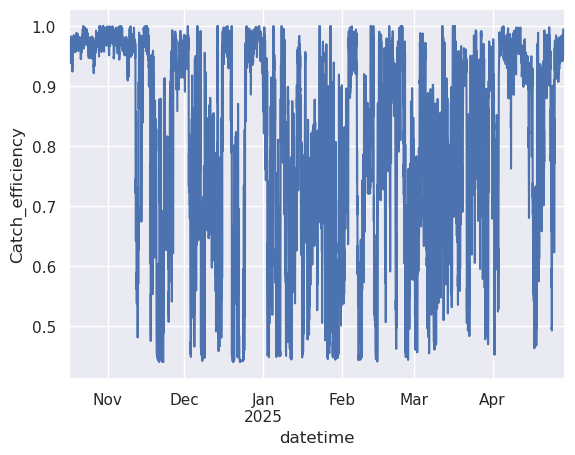

In [4]:
df.loc['2021-06' : '2025', 'catch_efficiency'] = fct.catch_efficiency_single_alter(df.loc['2021-06' : '2025', 'AirTC_Avg'], df.loc['2021-06' : '2025', 'WindSpeed_Avg'])
df.loc['2021-06' : '2025', 'catch_efficiency'].plot()
plt.ylabel("Catch_efficiency")

___
### Caption :
Catch efficiency depending on temperature and wind speed along the season: Correction of liquid and solid precipitation.
___

### Correction of precipitation

In [5]:
precip_snow_corr = precip_snow + ( 1 - df.loc[precip_snow.index,'catch_efficiency']) * precip_snow

df.loc[precip_snow_corr.index, 'Quantity_raw'] = precip_snow_corr

# III/ Gap fill the data

## III.1 Small Gap fill for all variable expect precipitation

### Write gap's length in the dataset

In [6]:
var_to_gapfill = variables
for var in var_to_gapfill :
    # gap's length written at the beginning of the gaps
    df['len_gap_'+var] = gp.calculate_length_gap(df[var])

    # Write the gap's at every row in all the data set
    df.loc[(df[var].isna() == False), 'len_gap_'+var] = 0
    df['len_gap_'+var] = df['len_gap_'+var].ffill()

## Interpolate data for smal gaps (1 to 6 missing values = max 3h) : method = linear
### Except for precipitation wich is for smaller gaps : 1 to 4 missing values = max 2h

In [7]:
df_filled = df.copy()

df_filled.loc[df_filled['len_gap_Quantity_raw'].isin([1,2,3,4]),'Quantity_raw'] = df_filled['Quantity_raw'].interpolate(method='linear')

for var in ['short_up_Avg', 'long_up_cor_Avg','AirTC_Avg', 'WindSpeed_Avg', 'Patm_Avg',  'HRair_Avg'] :
    df_filled.loc[df_filled['len_gap_'+var].isin([1,2,3,4,5,6]),var] = df_filled[var].interpolate(method='linear')

## III.2 Look at precipitation 

In [8]:
### Status
print(df_filled['Quantity_raw'].isna().sum())

276


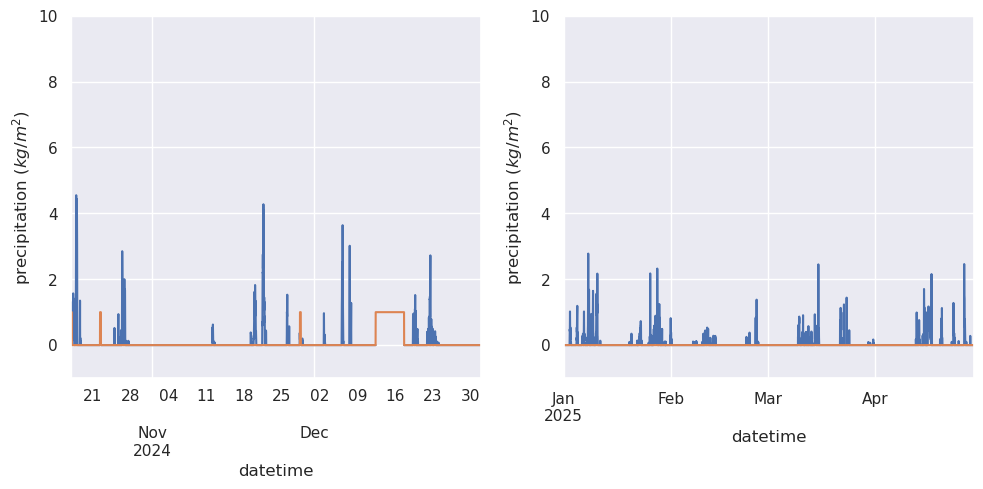

In [9]:
fig = plt.figure(figsize=(18, 16))
sns.set_theme()
fig.add_subplot(335)
df_filled['Quantity_raw'].loc['2024'].plot().set_ylim([-1,10])
df_filled['Quantity_raw'].loc['2024'].isna().astype(int).plot()
plt.ylabel("precipitation ($kg/m^2$)")
fig.add_subplot(336)
df_filled['Quantity_raw'].loc['2025'].plot().set_ylim([-1,10])
df_filled['Quantity_raw'].loc['2025'].isna().astype(int).plot()
plt.ylabel("precipitation ($kg/m^2$)")
plt.show()

### First method removes NaN if there is no precipitation, use of Lautaret Webcam

#### Oct 2024
No snow depth, It's not important for Crocus simulation.

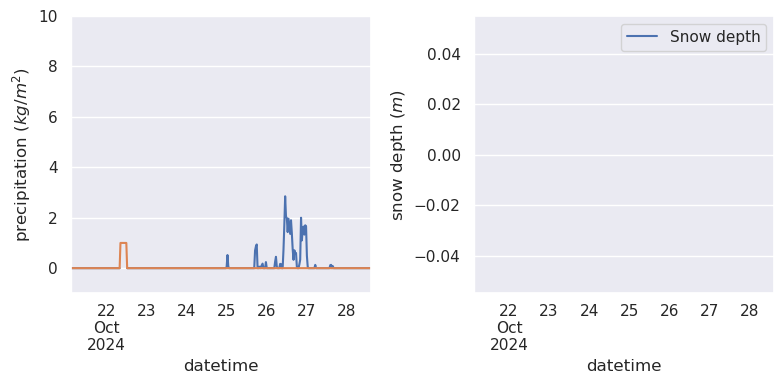

In [10]:
beg = '2024-10-21 3:00:00'
end = '2024-10-28 14:30:00'

fig = plt.figure(figsize=(8, 4))
sns.set_theme()

fig.add_subplot(121)
df_filled['Quantity_raw'].loc[beg:end].plot().set_ylim([-1,10])
df_filled['Quantity_raw'].loc[beg:end].isna().astype(int).plot()
plt.ylabel("precipitation ($kg/m^2$)")
fig.add_subplot(122)
df_filled['Snow_Depth'].loc[beg:end].plot(label="Snow depth")
plt.ylabel("snow depth ($m$)")
plt.tight_layout()
plt.legend()

### Identification Nov 2024

Webcam data aren't available, snow depth decrease. Possible black out. It's not important for Crocus simulation.

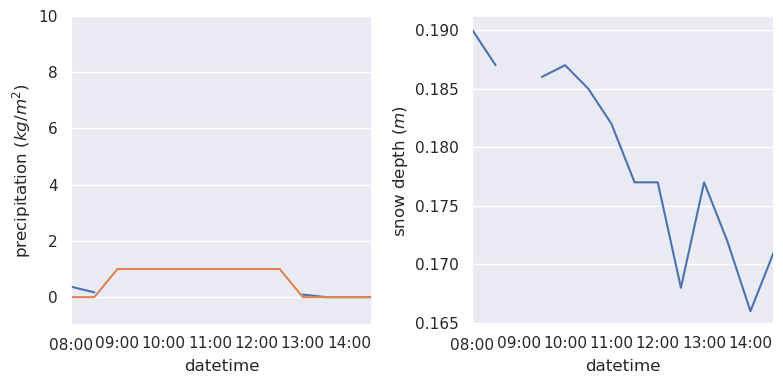

In [11]:
beg = '2024-11-28 8:00:00'
end = '2024-11-28 14:30:00'

fig = plt.figure(figsize=(8, 4))
sns.set_theme()

fig.add_subplot(121)
df_filled['Quantity_raw'].loc[beg:end].plot().set_ylim([-1,10])
df_filled['Quantity_raw'].loc[beg:end].isna().astype(int).plot()
plt.ylabel("precipitation ($kg/m^2$)")
fig.add_subplot(122)
df_filled['Snow_Depth'].loc[beg:end].plot(label="Snow depth")
plt.ylabel("snow depth ($m$)")
plt.tight_layout()

###  Identification Dec 2024

Information are lost due to a cap

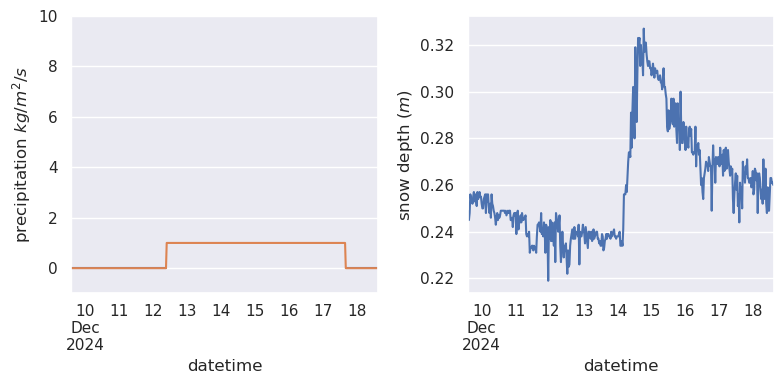

In [12]:
beg = '2024-12-09 14:00:00'
end = '2024-12-18 14:30:00'

fig = plt.figure(figsize=(8, 4))
sns.set_theme()

fig.add_subplot(121)
df_filled['Quantity_raw'].loc[beg:end].plot().set_ylim([-1,10])
df_filled['Quantity_raw'].loc[beg:end].isna().astype(int).plot()
plt.ylabel("precipitation ($kg/m^2$)")
plt.ylabel("precipitation $kg/m^2/s$")
fig.add_subplot(122)
df_filled['Snow_Depth'].loc[beg:end].plot(label="Snow depth")
plt.ylabel("snow depth ($m$)")
plt.tight_layout()

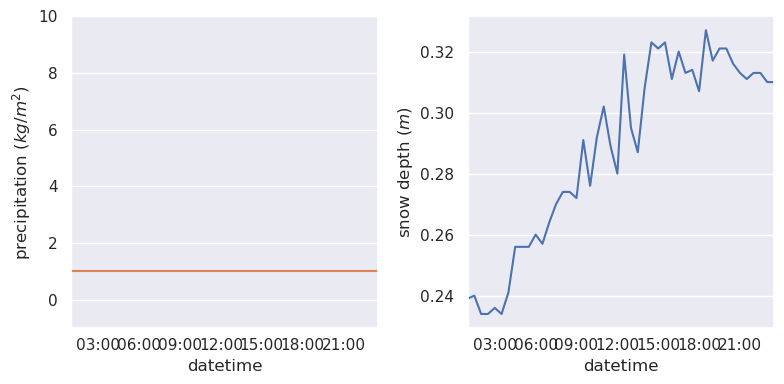

In [13]:
beg = '2024-12-14 1:00:00'
end = '2024-12-14 23:30:00'

fig = plt.figure(figsize=(8, 4))
sns.set_theme()

fig.add_subplot(121)
df_filled['Quantity_raw'].loc[beg:end].plot().set_ylim([-1,10])
df_filled['Quantity_raw'].loc[beg:end].isna().astype(int).plot()
plt.ylabel("precipitation ($kg/m^2$)")
fig.add_subplot(122)
df_filled['Snow_Depth'].loc[beg:end].plot(label="Snow depth")
plt.ylabel("snow depth ($m$)")
plt.tight_layout()

### Method : using crocus formula

#### 14 Dec 2024

In [14]:
## Episod from 15/12 3:00 to 15/12 14:30
beg = '2024-12-14 03:00:00'
end = '2024-12-14 23:30:00'

density_crocus = fct.densite_crocus(df.loc[beg:end , 'AirTC_Avg'].mean(), df.loc[beg:end, 'WindSpeed_Avg'].mean())
snow_acc = df.loc[end, 'Snow_Depth'] - df.loc[beg, 'Snow_Depth']
precip_corrected = density_crocus * snow_acc

print("The cumulated precipitation estimated for all the event thanks to the crocus density's formula is "
      +str(round(precip_corrected,2))+" mm, for a snow density of "+str(round(density_crocus, 2))+" kg/m3")
print("The remaining cumulated precip to fill is "
      +str(round((precip_corrected - df.loc[beg:end, 'Quantity_raw'].sum()),2))+" mm on "+str(df.loc[beg, 'len_gap_Quantity_raw']/2)+' h')

serie_to_fill = df_filled.loc[beg:end, 'Quantity_raw']
serie_to_fill.loc[df_filled['Quantity_raw'].isna()] = precip_corrected /len(serie_to_fill.loc[df_filled['Quantity_raw'].isna()])

The cumulated precipitation estimated for all the event thanks to the crocus density's formula is 10.11 mm, for a snow density of 136.55 kg/m3
The remaining cumulated precip to fill is 10.11 mm on 126.5 h


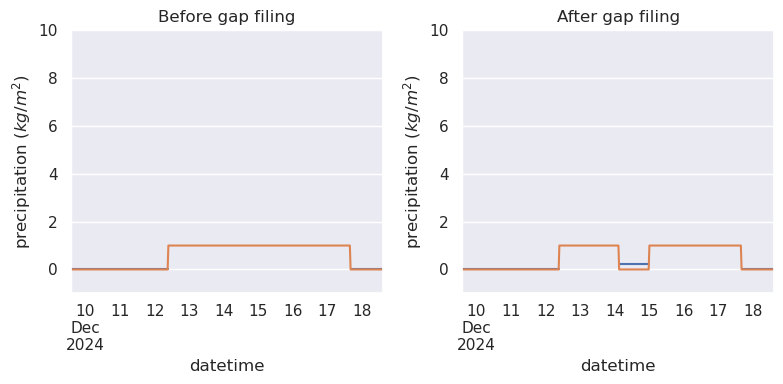

In [15]:
beg = '2024-12-09 14:00:00'
end = '2024-12-18 14:30:00'
fig = plt.figure(figsize=(8, 4))
sns.set_theme()

ax1 = fig.add_subplot(121)
df['Quantity_raw'].loc[beg:end].plot(ax=ax1)
df['Quantity_raw'].loc[beg:end].isna().astype(int).plot(ax=ax1)
plt.ylabel("precipitation ($kg/m^2$)")
plt.title("Before gap filing")
ax1.set_ylim([-1, 10])


df_filled.loc[serie_to_fill.index, 'Quantity_raw'] = serie_to_fill

ax1 = fig.add_subplot(122)
df_filled['Quantity_raw'].loc[beg:end].plot(ax=ax1)
plt.ylabel("precipitation ($kg/m^2$)")
df_filled['Quantity_raw'].loc[beg:end].isna().astype(int).plot(ax=ax1)
plt.title("After gap filing")
ax1.set_ylim([-1, 10])
plt.tight_layout()

In [16]:
## Last missing value
df_filled['Quantity_raw'] = df_filled['Quantity_raw'].fillna(0)

In [17]:
## Status
df_filled['Quantity_raw'].isna().sum()

np.int64(0)

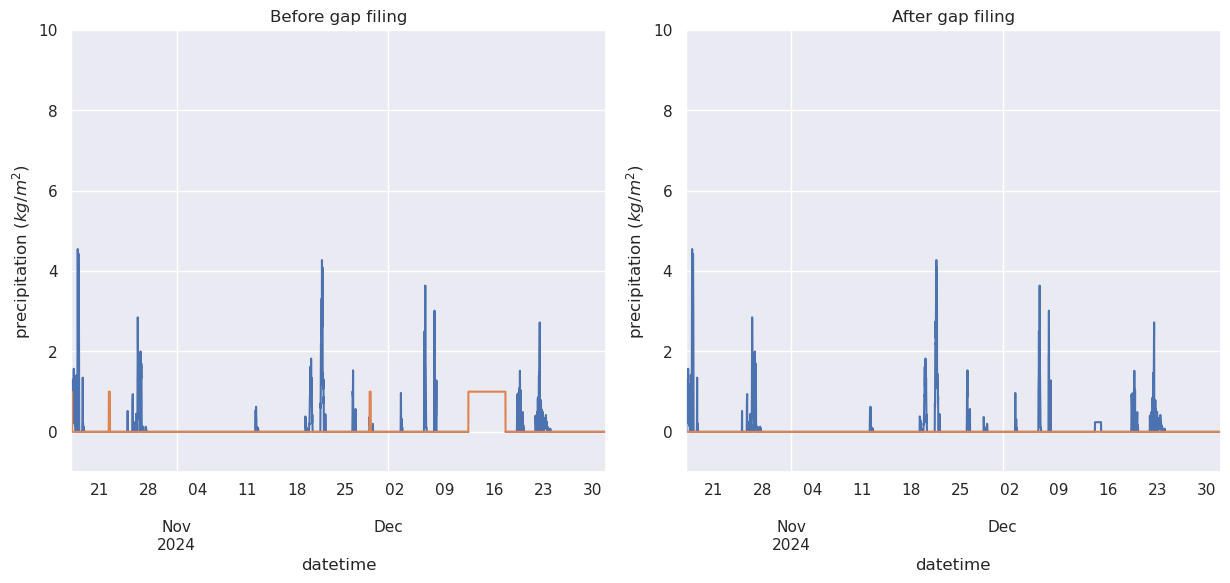

In [18]:
fig = plt.figure(figsize=(18, 16))
sns.set_theme()
fig.add_subplot(335)
plt.title("Before gap filing")
df['Quantity_raw'].loc['2024'].plot().set_ylim([-1,10])
df['Quantity_raw'].loc['2024'].isna().astype(int).plot()
plt.ylabel("precipitation ($kg/m^2$)")
fig.add_subplot(336)
plt.title("After gap filing")
df_filled['Quantity_raw'].loc['2024'].plot().set_ylim([-1,10])
df_filled['Quantity_raw'].loc['2024'].isna().astype(int).plot()
plt.ylabel("precipitation ($kg/m^2$)")
plt.tight_layout()

## III.3 Overlook of all variable

In [19]:
df_final = df_filled.combine_first(df)

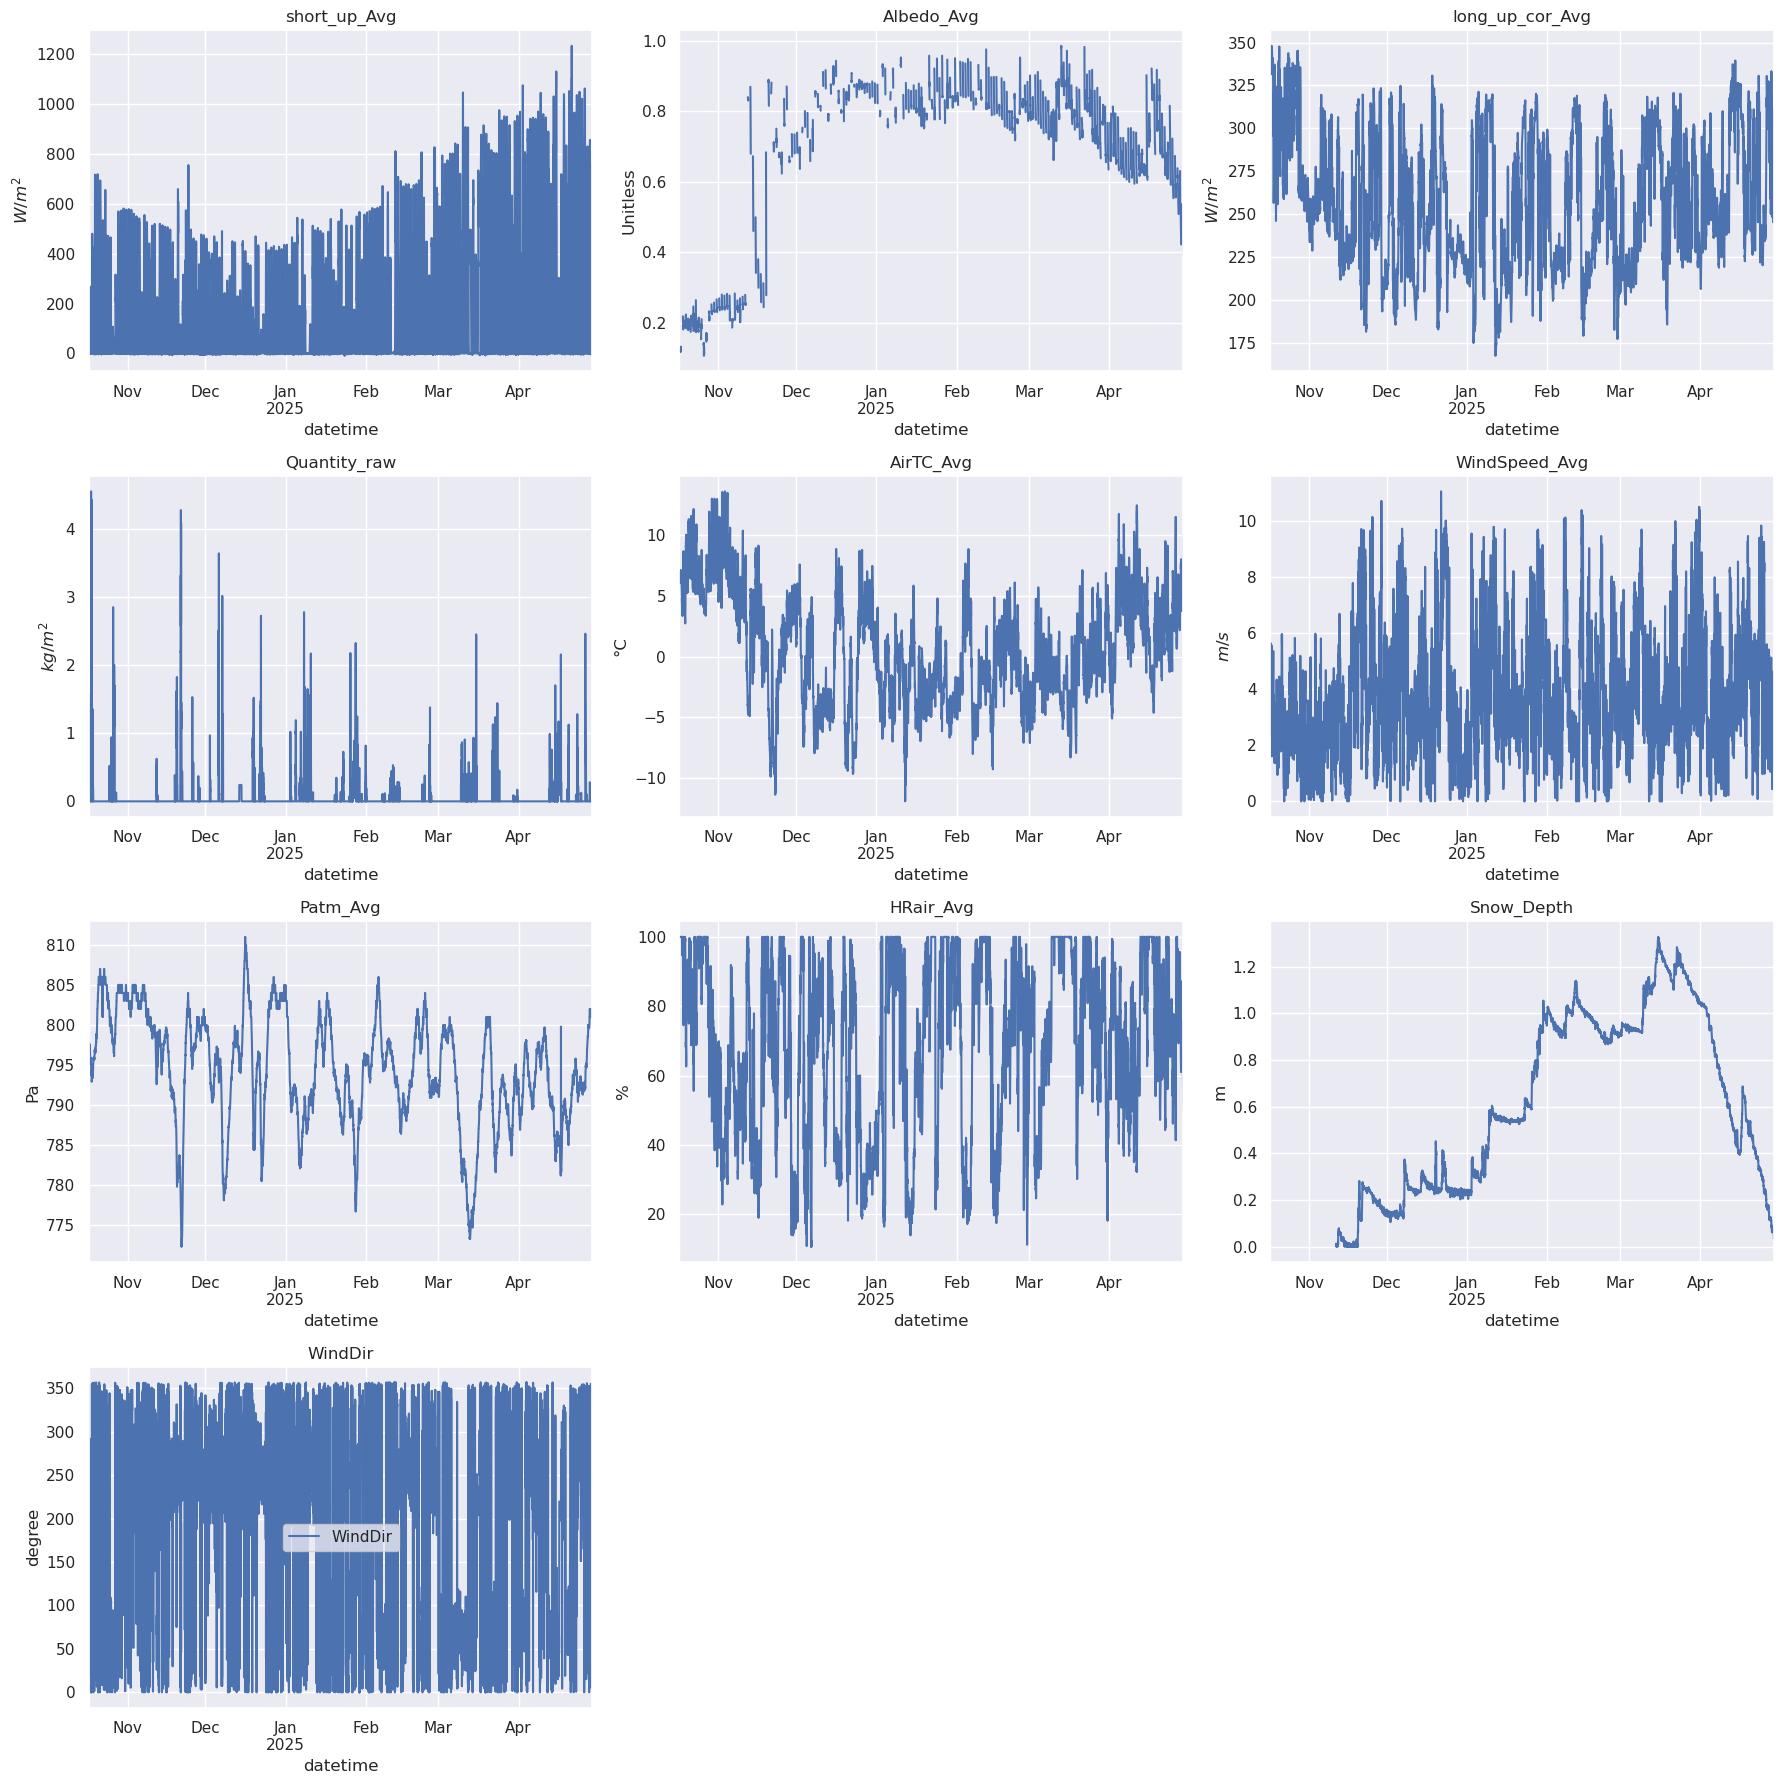

In [20]:
Columns= variables


Units = ["$W/m^2$","Unitless","$W/m^2$","$kg/m^2$","°C","$m/s$","Pa","%","m","degree"]
fig = plt.figure(figsize=(18, 18))
i=0
for column in Columns:
    i=i+1
    fig.add_subplot(4,3,i)
    df_final[column].plot()
    plt.ylabel(Units[i-1])
    plt.title(str(column))
plt.tight_layout()
plt.legend()
plt.show()

# IV/ Precipitation reconstruction:
This section aims to reconstruct precipitation from snow depth measurements. This is necessary because precipitation observations do not fully capture total snow accumulation, leading to an underestimation of snow height in simulations. The methodology is fully developed in the notebook `Crocus_Snow-depth_obs_vs_simu.ipynb`. 

Because classic precipitation corrections do not match the observed snow depth, I
explored another method for reconstructing precipitation. The same approach used for
precipitation gap-filling was applied to the entire 2025 season. Snow depth observations are used to recontruct snow events. An interval-based discretization was
used to divide the season into a temporal grid. Within each interval, the observed snow
depth difference was calculated. To reduce the impact of measurement noise, a threshold
of 5 cm was applied. When the snow depth change exceeded this threshold, a snow event
was identified. The fresh snow density is calculated using Equation A.3, which allows the
calculation of the amount of precipitation.

In [21]:
# Loc only variable of interest.
df_sacc = df_final.loc[:,['Snow_Depth','AirTC_Avg','WindSpeed_Avg']]
# Comput precip
df_sacc_prep_6h = pr.calculate_precipitation_smoothed(df_sacc, interval=6,threshold=0.05)
df_sacc_prep_24h = pr.calculate_precipitation_smoothed(df_sacc, interval=24,threshold=0.05)

In [22]:
df_final_6h=df_final.copy(deep=True)
df_final_24h=df_final.copy(deep=True)

# Assign new precips
df_final_6h.Quantity_raw = df_sacc_prep_6h.Precip_Calculated
df_final_24h.Quantity_raw = df_sacc_prep_24h.Precip_Calculated

# Save csv
Chek name for save

In [23]:
0/0

ZeroDivisionError: division by zero

In [24]:
path ="~/private-storage/Data_internship_2025_GP/Crocus/Gapfilled_data_FluxAlps_2024_2025/"

df_final.to_csv(path+"2024-2025_Lautaret_halfhour.csv")
df_final_6h.to_csv(path+"2024-2025_Lautaret_halfhour_6h.csv")
df_final_24h.to_csv(path+"2024-2025_Lautaret_halfhour_24h.csv")